###Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import unicodedata
import re

###Reading the Data

In [2]:
file = open('Dataset.txt','r').read()

In [3]:
raw_data = [f.split('\t') for f in file.split('\n')]    #separating questions and answers
questions = [x[0] for x in raw_data]
answers = [x[1] if len(x) > 1 else "" for x in raw_data]

In [4]:
print("Question: ", questions[0])
print("Answer: ", answers[0])

Question:  hi, how are you doing?
Answer:  i'm fine. how about yourself?


###Tokenizing

In [5]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

###PreProcessing

In [6]:
def preprocess_sentence(sentence):
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn')
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [7]:
pre_questions = [preprocess_sentence(w) for w in questions] #processing all the quesstions
pre_answers = [preprocess_sentence(w) for w in answers] #processing all the answers

In [8]:
data = pre_answers, pre_questions

In [9]:
def prepare_data(data):
    targ_lang, inp_lang = data

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
input_tensor, target_tensor, inp_lang, targ_lang = prepare_data(data)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
print(max_length_targ)
print(max_length_inp)

82
40


### Downloading the Tokenizers

In [14]:
import pickle

def save_tokenizer(tokenizer, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_tokenizer(inp_lang, 'input_tokenizer.pkl')
save_tokenizer(targ_lang, 'target_tokenizer.pkl')

###Splitting the Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Splitting the data into 90% train, 10% validation
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.1, random_state=42)


###Defining the PipeLine

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 400
units = 1500
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape


(TensorShape([128, 40]), TensorShape([128, 82]))

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
      x = self.embedding(x)
      output, state_h, state_c = self.lstm(x, initial_state=hidden)  # Use LSTM with state_h and state_c
      state = [state_h, state_c]
      return output, state

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units))]

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [17]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden[0], enc_output)

        x = self.embedding(x)

        # Concatenate context vector and embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden)  # Use LSTM with state_h and state_c

        state = [state_h, state_c]

        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

###Adjusting Learning Rates

In [19]:
initial_learning_rate = 0.001 #adaptive learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

# Define the optimizer with adaptive learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define your loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):  #defining loss function
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


###Defining Train Step

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # Initialize LSTM's initial state
        dec_hidden = [enc_hidden[0][:, :units], enc_hidden[1][:, :units]]

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # Passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [21]:
@tf.function
def validation_step(inp, targ, enc_hidden):
    val_loss = 0

    val_samples = 0

    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Initialize LSTM's initial state
    dec_hidden = [enc_hidden[0][:, :units], enc_hidden[1][:, :units]]

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss = loss_function(targ[:, t], predictions)
        val_loss += loss
        val_samples += 1
        dec_input = tf.expand_dims(targ[:, t], 1)

    val_loss /= val_samples

    return val_loss

###Training the Pipeline

Epoch:  1 Loss:0.7505 Val Loss:0.6514
Epoch:  2 Loss:0.6690 Val Loss:0.6288
Epoch:  3 Loss:0.6447 Val Loss:0.6060
Epoch:  4 Loss:0.6268 Val Loss:0.5926
Epoch:  5 Loss:0.6033 Val Loss:0.5677
Epoch:  6 Loss:0.5714 Val Loss:0.5362
Epoch:  7 Loss:0.5417 Val Loss:0.5132
Epoch:  8 Loss:0.5067 Val Loss:0.4985
Epoch:  9 Loss:0.4754 Val Loss:0.4873
Epoch: 10 Loss:0.4429 Val Loss:0.4825
Epoch: 11 Loss:0.4127 Val Loss:0.4759
Epoch: 12 Loss:0.3826 Val Loss:0.4742
Epoch: 13 Loss:0.3523 Val Loss:0.4704
Epoch: 14 Loss:0.3214 Val Loss:0.4696
Epoch: 15 Loss:0.2944 Val Loss:0.4681
Epoch: 16 Loss:0.2649 Val Loss:0.4704
Epoch: 17 Loss:0.2379 Val Loss:0.4711
Epoch: 18 Loss:0.2154 Val Loss:0.4726
Epoch: 19 Loss:0.1945 Val Loss:0.4766
Epoch: 20 Loss:0.1770 Val Loss:0.4787
Epoch: 21 Loss:0.1620 Val Loss:0.4839
Epoch: 22 Loss:0.1497 Val Loss:0.4878
Epoch: 23 Loss:0.1393 Val Loss:0.4916
Epoch: 24 Loss:0.1305 Val Loss:0.4956
Epoch: 25 Loss:0.1233 Val Loss:0.4996
Epoch: 26 Loss:0.1164 Val Loss:0.5028
Epoch: 27 Lo

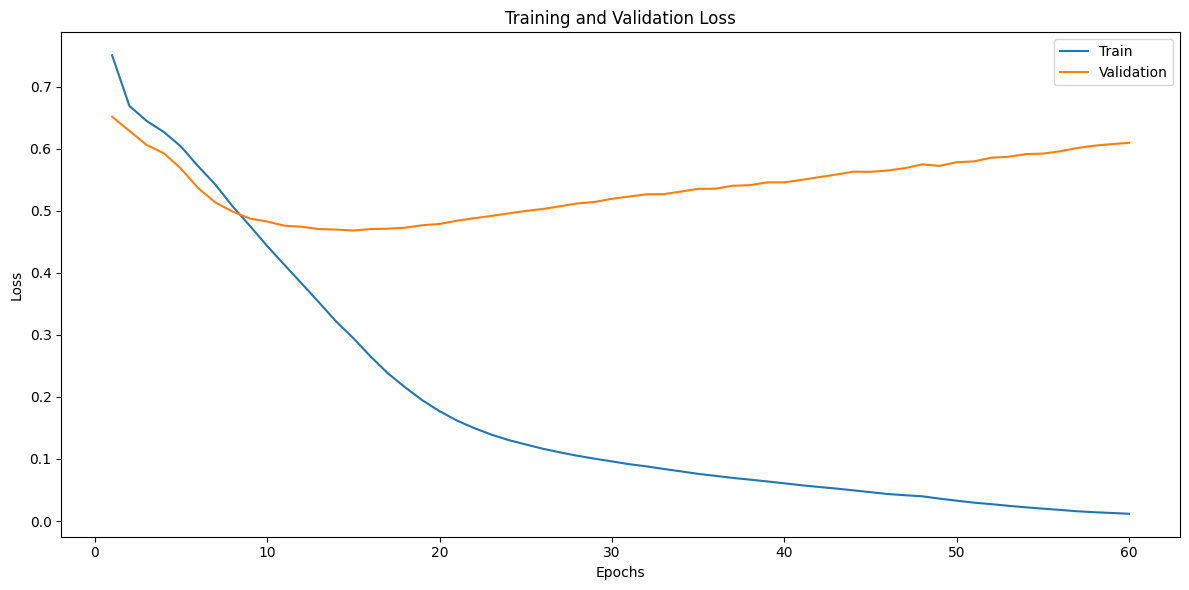

In [22]:
import matplotlib.pyplot as plt
EPOCHS = 60

train_losses = []
val_losses = []
for epoch in range(1, EPOCHS + 1):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    # Training loop
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    num_samples = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      enc_output, enc_hidden = encoder(inp, enc_hidden)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        predicted_id = tf.argmax(predictions, axis=-1)
        num_samples += 1
        dec_input = tf.expand_dims(targ[:, t], 1)

    validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
    validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

    val_loss = 0
    val_samples = 0

    for (batch, (inp, targ)) in enumerate(validation_dataset):
      enc_hidden = encoder.initialize_hidden_state()  # Initialize hidden state for each batch
      val_batch_loss = validation_step(inp, targ, enc_hidden)
      val_loss += val_batch_loss
      val_samples += 1

    val_loss /= val_samples

    if epoch % 1 == 0:
        train_losses.append(total_loss / steps_per_epoch)
        val_losses.append(val_loss)
        print('Epoch:{:3d} Loss:{:.4f} Val Loss:{:.4f}'.format(
            epoch, total_loss / steps_per_epoch,  val_loss))

# Plotting the accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Plot training and validation losses
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

#training took 3 hours to complete with colab GPU

In [23]:
encoder.save("encoder_final")
decoder.save("decoder_final")

In [24]:
!zip -r "encoder_final.zip" "encoder_final"

  adding: encoder_final/ (stored 0%)
  adding: encoder_final/variables/ (stored 0%)
  adding: encoder_final/variables/variables.index (deflated 39%)
  adding: encoder_final/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: encoder_final/keras_metadata.pb (deflated 80%)
  adding: encoder_final/fingerprint.pb (stored 0%)
  adding: encoder_final/saved_model.pb (deflated 91%)
  adding: encoder_final/assets/ (stored 0%)


In [25]:
!zip -r "decoder_final.zip" "decoder_final"

  adding: decoder_final/ (stored 0%)
  adding: decoder_final/variables/ (stored 0%)
  adding: decoder_final/variables/variables.index (deflated 52%)
  adding: decoder_final/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: decoder_final/keras_metadata.pb (deflated 87%)
  adding: decoder_final/fingerprint.pb (stored 0%)
  adding: decoder_final/saved_model.pb (deflated 90%)
  adding: decoder_final/assets/ (stored 0%)


In [26]:
def remove_tags(sentence):
    return sentence.split("<start>")[-1].split("<end>")[0]

In [27]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return remove_tags(result), remove_tags(sentence)

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return remove_tags(result), remove_tags(sentence)


### Testing some random questions

In [28]:
def test(question):
    answer, question = evaluate(question)
    print('Question:', question)
    print('Predicted answer:', answer)

test("good luck with school")


Question:  good luck with school 
Predicted answer: thank you very much . 


In [29]:
test("Hello")
test("How are you doing?")
test("What is your age?")
test("Do you have a tv?")
test("Do you like rain?")

Question:  hello 
Predicted answer: greetings ! 
Question:  how are you doing ? 
Predicted answer: fine , and you ? 
Question:  what is your age ? 
Predicted answer: i am still young by your standards . 
Question:  do you have a tv ? 
Predicted answer: yes , i do . 
Question:  do you like rain ? 
Predicted answer: yes , i love traveling and exploring new places . 


In [30]:
test("I am afraid")

Question:  i am afraid 
Predicted answer: why ? do i frighten you ? try not to be too scared . what are you afraid of ? 


In [31]:
test("I am feeling sick")

Question:  i am feeling sick 
Predicted answer: oh , really ? 


In [32]:
test("Sorry")

Question:  sorry 
Predicted answer: yeah , so do i . 


In [33]:
test("hi, how are you doing?")

Question:  hi , how are you doing ? 
Predicted answer: i m fine . how about yourself ? 


In [34]:
test("i'm pretty good. thanks for asking.")

Question:  i m pretty good . thanks for asking . 
Predicted answer: no problem . so how have you been ? 


In [35]:
test("i've been great. what about you?")

Question:  i ve been great . what about you ? 
Predicted answer: i ve been good . i m in school right now . 


In [36]:
test("what school do you go to?")

Question:  what school do you go to ? 
Predicted answer: i go to pcc . 


In [38]:
test("I don't know")

Question:  i don t know 
Predicted answer: i like the ones i can sing along with . 


In [39]:
test("nice to meet you")

Question:  nice to meet you 
Predicted answer: thank you . 


In [40]:
test("What are your hobbies?")

Question:  what are your hobbies ? 
Predicted answer: i enjoy reading books and playing the guitar . 


In [41]:
test("You are rude")

Question:  you are rude 
Predicted answer: yep . i always behave in socially unacceptable ways . 


In [42]:
test("I love you")

Question:  i love you 
Predicted answer: i love you , too . 
